Pawan Jayakumar, Ho Yeon Jeong, Alan Zheng

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
class Exp3:
    def __init__(self, k, gamma=0.1):
        self.k = k
        self.weights = np.ones(k)
        self.gamma = gamma
        self.probabilities = np.ones(k)
        
    def select_arm(self):
        self.probabilities = (1 - self.gamma) * self.weights / np.sum(self.weights) + self.gamma / self.k
        return np.random.choice(self.k, p=self.probabilities)

    def update(self, arm, reward):
        estimated_reward = 1.0 * reward / self.probabilities[arm]
        #print(estimated_reward)
        self.weights[arm] *= np.exp((self.gamma / self.k) * estimated_reward)




In [3]:
class UCB1:
    def __init__(self, k, alpha=0.0):
        self.k = k
        self.alpha = alpha
        self.arm_estimated_mean = np.zeros(self.k)
        self.arm_counts = np.zeros(self.k)
        self.t = 0

    def select_arm(self):
        max_val = float('-inf')
        max_arm = None

        for arm in range(self.k):
            if self.arm_counts[arm] == 0:
                return arm
            val = self.arm_estimated_mean[arm] + np.sqrt(2 * np.log(self.t) / self.arm_counts[arm]) * self.alpha
            
            if max_val < val:
                max_arm = arm
                max_val = val

        return max_arm

    def update(self, chosen_arm, reward):
        self.arm_estimated_mean[chosen_arm] = ((self.arm_estimated_mean[chosen_arm] * self.arm_counts[chosen_arm] + reward)
                                               / (self.arm_counts[chosen_arm] + 1))
        self.arm_counts[chosen_arm] += 1
        self.t += 1

In [4]:
from enum import Enum
class Question(Enum):
    P1 = 1
    P2 = 2
    P3 = 3
    P4 = 4
    P5 = 5


In [5]:

def run_alg(t, k=20, m=10, n=400, question = Question.P1, ucb_frac = 0, verbose = False):
    # m creator
    # k content options
    # n users
    # create an array to store the rewards obtained by each player in each round
    rewards = np.zeros((t, m))
    # print(rewards)

    # create an array of m instances of the Exp3 algorithm
    players = [Exp3(k) for i in range(m)]
    
    num_ucb = int(ucb_frac * m)
    for i in range(num_ucb):
        players[i] = UCB1(k, alpha=0.05)

    # create the utility matrix
    utility = np.random.uniform(0,1, (k, n))

    total_welfare = 0
    ucb_welfare = 0
    exp_welfare = 0
    # run the simulation for t rounds
    for t in range(t):
        # each player selects an arm
        arms = np.array([player.select_arm() for player in players],dtype=int) # size m
        
        # content_util = np.zeros((n,m))
        # for user in range(n):
        #     content_util[user] = np.array([ utility[i,user] for i in arms])
        #     if question == Question.P3:
        #         content_util = np.softmax(content_util)
        
         

        # determining user choice

        for user in range(n):
            maxind = []
            max = 0
            for player in range(m):
                util = utility[arms[player], user]
                #if the player gives the most utility for the user, save them
                if max < util:
                    max = util
                    maxind = [player]
                elif max==util:
                    maxind.append(player)

            total_welfare += max
            best_chosen_ind = int(random.choice(maxind))
            if best_chosen_ind < num_ucb:
                ucb_welfare += max
            else:
                exp_welfare += max
            
            if question == Question.P1:
                rewards[t, best_chosen_ind]+=1
            elif question == Question.P2:
                rewards[t,best_chosen_ind]+= max+np.random.normal()
            else:
                rewards[t, best_chosen_ind]+=1
                
#             match(question):
#                 case Question.P1:  
#                     rewards[t, int(random.choice(maxind))]+=1
#                 case Question.P2:
#                     rewards[t,int(np.random.choice(maxind))]+= max+np.random.normal()
#                 case _ :
#                     rewards[t, int(np.random.choice(maxind))]+=1

        # each player receives the reward for the arm they selected
        for creator, arm in enumerate(arms):
            players[creator].update(arm, rewards[t, creator])

    if verbose:
        if ucb_frac != 0 and ucb_frac != 1:
            print("Average UCB attributed welfare: %.3f" % (ucb_welfare / num_ucb))
            print("Average EXP attributed welfare: %.3f" % (exp_welfare / (m - num_ucb)))
        elif ucb_frac == 0:
            print("No UCB players.")
            print("Average EXP attributed welfare: %.3f" % (exp_welfare / (m - num_ucb)))
        else:
            print("No EXP players.")
            print("Average UCB attributed welfare: %.3f" % (ucb_welfare / num_ucb))
    
    return total_welfare



In [6]:
num_k = [10, 50, 100, 500, 1000]
k_arr = []  
for k in tqdm(num_k):
    k_arr.append(run_alg(t=100, k=k))
print(k_arr)


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

[35373.44976733213, 36347.283609571045, 36492.51975854412, 36594.02697048118, 36535.64940903341]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


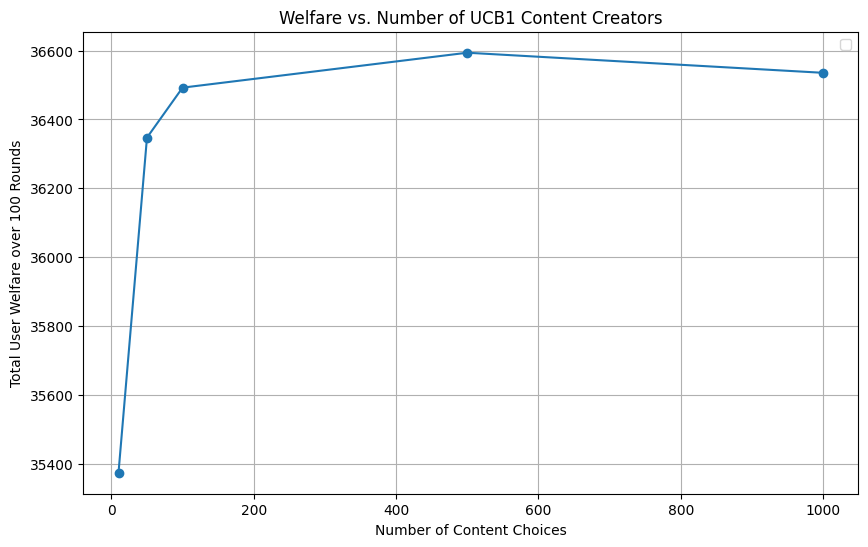

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(num_k, k_arr, marker='o')

plt.xlabel('Number of Content Choices')
plt.ylabel('Total User Welfare over 100 Rounds')
plt.title('Welfare vs. Number of UCB1 Content Creators')
plt.legend()
plt.grid()
plt.show()

In [8]:
num_n = [5, 10, 50, 100, 500, 1000, 5000]
n_arr = []
for n in tqdm(num_n):
    n_arr.append(run_alg(t=100, k=100, m=100, n=n))
print(n_arr)



100%|██████████| 7/7 [00:29<00:00,  4.26s/it]

[491.2341966160543, 980.1005486006152, 4913.018621800428, 9860.525020606694, 49251.522093124055, 98541.20789858043, 493178.2196041732]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


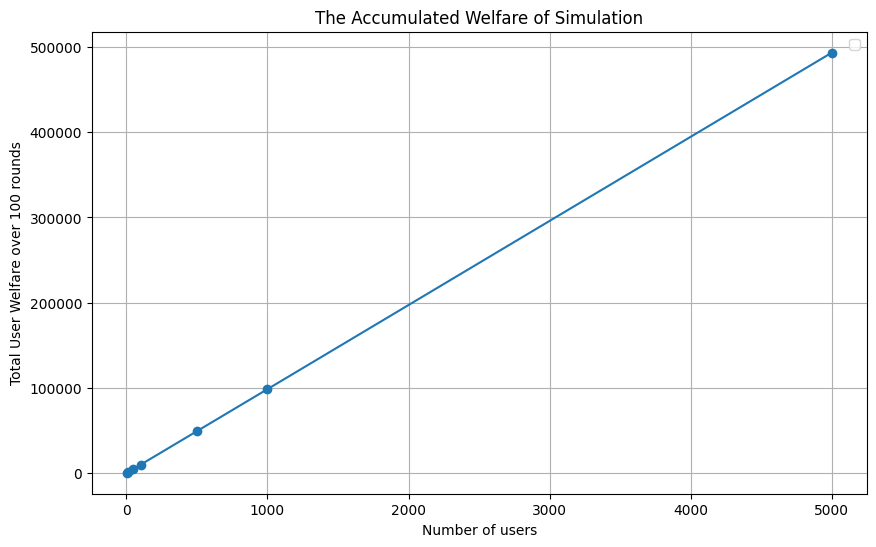

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(num_n, n_arr, marker='o')

plt.xlabel('Number of users')
plt.ylabel('Total User Welfare over 100 rounds')
plt.title('The Accumulated Welfare of Simulation')
plt.legend()
plt.grid()
plt.show()

In [10]:
num_m = [2, 5, 10, 50, 100]
m_arr = []
for m in tqdm(num_m):
    m_arr.append(run_alg(t=100, k=100, m=m))
print(m_arr)


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

[26794.762313704, 33505.034444464734, 36480.56681129643, 39002.76829805434, 39400.92545320091]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


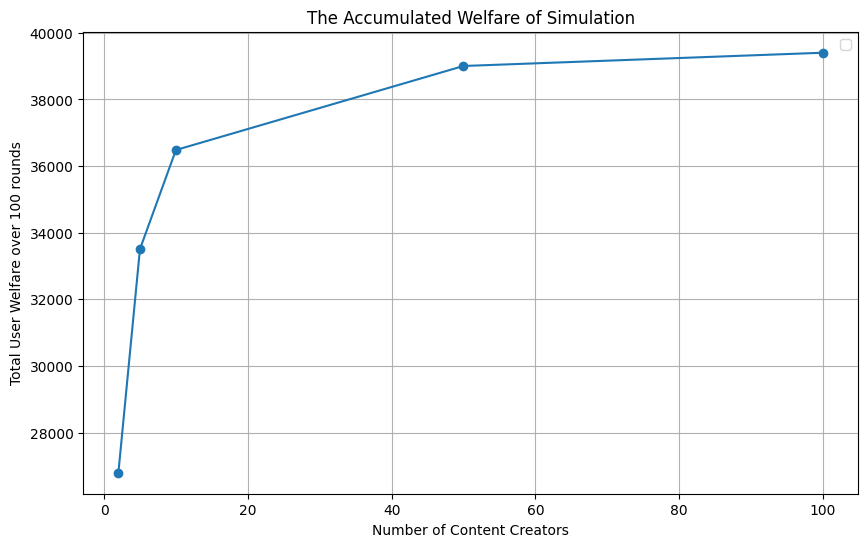

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(num_m, m_arr, marker='o')

plt.xlabel('Number of Content Creators')
plt.ylabel('Total User Welfare over 100 rounds')
plt.title('The Accumulated Welfare of Simulation')
plt.legend()
plt.grid()
plt.show()

In [12]:
ucb_fracs = [0, 0.25, 0.5, 0.75, 1]

In [13]:
ucb_k_arr = []  
for frac in ucb_fracs:
    ucb_k_arr.append([])
    for k in tqdm(num_k):
#         print("UCB Frac: %.1f, k: %d" % (frac, k))
        ucb_k_arr[-1].append(run_alg(t=100, k=k, ucb_frac = frac))
#         print()
print(ucb_k_arr)


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

[[35359.780689805644, 36258.12446269917, 36482.18962624274, 36405.35352271221, 36606.526705355616], [35224.06856481096, 36216.59416117428, 35976.23653450687, 36254.36697171855, 36138.594911052685], [35251.21406650204, 35088.31039196967, 34300.22895827739, 34401.48437958107, 34503.904533448345], [34148.497287681705, 33975.36439196317, 32000.991495613056, 32166.34427469536, 32213.439870724087], [34492.08573755003, 28087.242113832053, 19986.64817346455, 19931.270779021055, 19914.830290644826]]


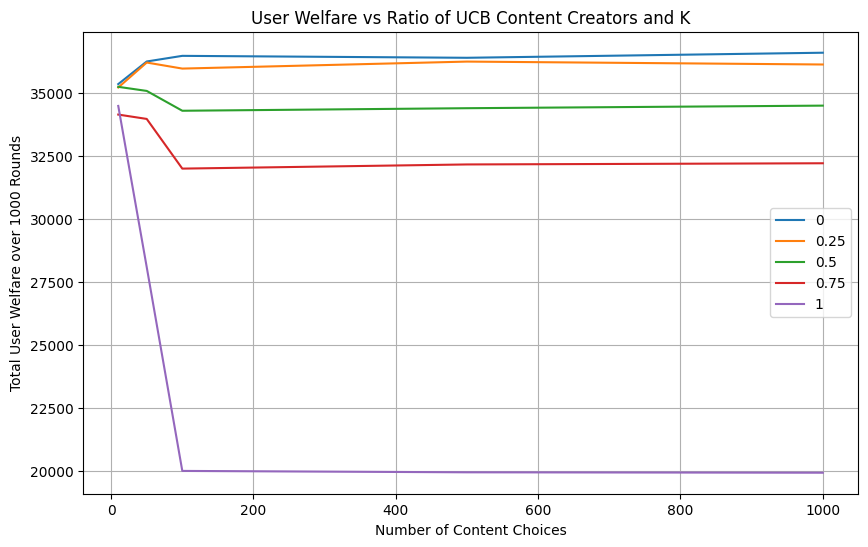

In [14]:
plt.figure(figsize=(10, 6))

for frac, data in zip(ucb_fracs, ucb_k_arr):
    plt.plot(num_k, data, label = str(frac))

plt.xlabel('Number of Content Choices')
plt.ylabel('Total User Welfare over 1000 Rounds')
plt.title('User Welfare vs Ratio of UCB Content Creators and K')
plt.legend()
plt.grid()
plt.show()

In [15]:
ucb_n_arr = []

for frac in ucb_fracs:
    ucb_n_arr.append([])
    for n in tqdm(num_n):
        ucb_n_arr[-1].append(run_alg(t=100, k=100, m=100, n=n, ucb_frac = frac))
print(ucb_n_arr)



100%|██████████| 7/7 [00:39<00:00,  5.63s/it]

[[489.42262954816596, 978.6251902420496, 4925.385666448334, 9853.417472246503, 49219.63475997638, 98491.95944136534, 493063.2088413231], [493.8131577804062, 981.6074624285136, 4904.1086206068885, 9822.70525202095, 49071.509518402236, 98262.5732532059, 491948.7525364273], [487.95161524542016, 976.1214817162802, 4883.999542943065, 9757.789405557263, 48808.04311944809, 97814.21054189555, 489034.12315025995], [478.0201441475462, 961.2871709522428, 4795.99263991811, 9588.907886966912, 48133.261152459505, 96272.28498792213, 480289.88968222233], [237.8055033501215, 510.3178234029424, 2513.3936658103803, 5012.732846518337, 24877.777232442448, 50106.19113505649, 250221.27617242333]]


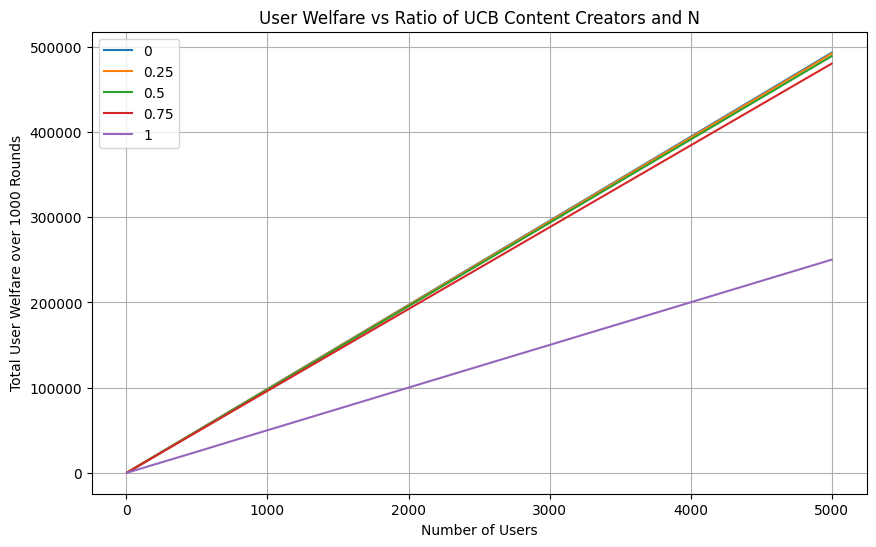

In [16]:
plt.figure(figsize=(10, 6))
for frac, data in zip(ucb_fracs, ucb_n_arr):
    plt.plot(num_n, data, label = str(frac))

plt.xlabel('Number of Users')
plt.ylabel('Total User Welfare over 1000 Rounds')
plt.title('User Welfare vs Ratio of UCB Content Creators and N')
plt.legend()
plt.grid()
plt.show()

In [17]:
ucb_m_arr = []

for frac in ucb_fracs:
    ucb_m_arr.append([])
    for m in tqdm(num_m):
        ucb_m_arr[-1].append(run_alg(t=100, k=100, m=m, ucb_frac = frac))
print(ucb_m_arr)



100%|██████████| 5/5 [00:06<00:00,  1.22s/it]

[[27130.27823180624, 33111.13704380741, 36538.027241331394, 39050.965398394634, 39408.72784336448], [27310.33375300832, 33546.741752173046, 36147.37723825699, 38833.15307114249, 39265.38340119175], [26583.32729264954, 32004.885558083497, 34347.502579373424, 38464.69229478727, 39041.514052713996], [26536.204687941736, 30069.97018588611, 32106.014337389097, 37397.80791484498, 38415.42566328471], [19980.03752909206, 19954.07540546174, 20122.181658126443, 19983.9545849823, 19925.31860419181]]


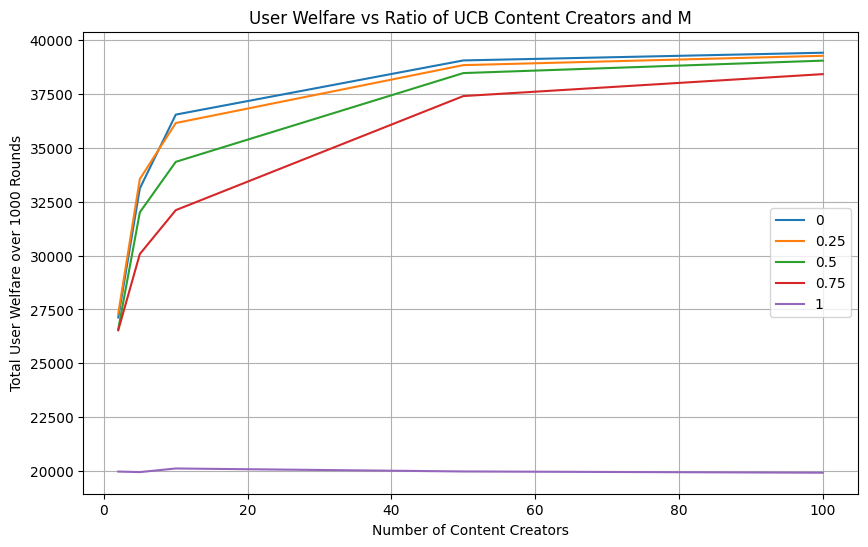

In [18]:
plt.figure(figsize=(10, 6))
for frac, data in zip(ucb_fracs, ucb_m_arr):
    plt.plot(num_m, data, label = str(frac))

plt.xlabel('Number of Content Creators')
plt.ylabel('Total User Welfare over 1000 Rounds')
plt.title('User Welfare vs Ratio of UCB Content Creators and M')
plt.legend()
plt.grid()
plt.show()

In [27]:

def sub_run_alg(t, k=20, m=10, n=400, sub_thresh = 3, watch_sub = 0.1):
    # m creator
    # k content options
    # n users
    # create an array to store the rewards obtained by each player in each round
    rewards = np.zeros((t, m))
    views = np.zeros((n, m)) # number of times each user selects a creator
    avg_utility = []
    for _ in range(m):
        avg_utility.append([0, 0])
    # print(rewards)

    # create an array of m instances of the Exp3 algorithm
    players = [Exp3(k) for i in range(m)]

    # create the utility matrix
    utility = np.random.uniform(0,1, (k, n))

    total_welfare = 0
    # run the simulation for t rounds
    for t in range(t):
        # each player selects an arm
        arms = np.array([player.select_arm() for player in players],dtype=int) # size m
         

        # determining user choice

        for user in range(n):
            subscribed = np.where(views[user] > sub_thresh)[0]
            if random.random() < watch_sub and len(subscribed) > 0:
                maxind = [np.argmax(subscribed)]
                max = utility[arms[maxind[0]], user]
                views[user, maxind[0]] -= 1
            else:
                maxind = []
                max = 0
                for player in range(m):
                    util = utility[arms[player], user]
                    #if the player gives the most utility for the user, save them
                    if max < util:
                        max = util
                        maxind = [player]
                    elif max==util:
                        maxind.append(player)

            total_welfare += max
            best_chosen_ind = int(random.choice(maxind))
            
            avg_utility[best_chosen_ind][1] = (avg_utility[best_chosen_ind][1] * avg_utility[best_chosen_ind][0]
                                               + max) / (avg_utility[best_chosen_ind][0] + 1)
            avg_utility[best_chosen_ind][0] += 1
            
            views[user, best_chosen_ind] += 1
            
            rewards[t, best_chosen_ind] += 1

        # each player receives the reward for the arm they selected
        for creator, arm in enumerate(arms):
            players[creator].update(arm, rewards[t, creator])
            
    subscribers = [0] * m
    for user in range(n):
        subscribed = np.where(views[user] > sub_thresh)[0]
        for sub in subscribed:
            subscribers[sub] += 1

    plot = []
    for creator, subs in enumerate(subscribers):
        print("Creator %d: Average Utility = %.5f, Subscribers = %d" % (creator, avg_utility[creator][1], subs))
        plot.append((avg_utility[creator][1], subs))
        
#     print(views[0])
    return total_welfare, plot




In [28]:
num_sub = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
sub_arr = []
sub_util = []  
for sub in tqdm(num_sub):
    welfare, subs = sub_run_alg(t=100, watch_sub = sub)
    sub_arr.append(welfare)
    sub_util.append(subs)

print(sub_arr)


  7%|▋         | 1/14 [00:00<00:10,  1.29it/s]

Creator 0: Average Utility = 0.89007, Subscribers = 210
Creator 1: Average Utility = 0.89558, Subscribers = 159
Creator 2: Average Utility = 0.88396, Subscribers = 195
Creator 3: Average Utility = 0.90461, Subscribers = 162
Creator 4: Average Utility = 0.89196, Subscribers = 197
Creator 5: Average Utility = 0.90078, Subscribers = 186
Creator 6: Average Utility = 0.89723, Subscribers = 201
Creator 7: Average Utility = 0.89815, Subscribers = 220
Creator 8: Average Utility = 0.90020, Subscribers = 192
Creator 9: Average Utility = 0.89083, Subscribers = 191


 14%|█▍        | 2/14 [00:01<00:08,  1.40it/s]

Creator 0: Average Utility = 0.86881, Subscribers = 125
Creator 1: Average Utility = 0.85632, Subscribers = 129
Creator 2: Average Utility = 0.86319, Subscribers = 187
Creator 3: Average Utility = 0.85877, Subscribers = 181
Creator 4: Average Utility = 0.88164, Subscribers = 195
Creator 5: Average Utility = 0.88784, Subscribers = 193
Creator 6: Average Utility = 0.89429, Subscribers = 228
Creator 7: Average Utility = 0.89678, Subscribers = 159
Creator 8: Average Utility = 0.89913, Subscribers = 179
Creator 9: Average Utility = 0.91183, Subscribers = 209


 21%|██▏       | 3/14 [00:02<00:07,  1.47it/s]

Creator 0: Average Utility = 0.85010, Subscribers = 170
Creator 1: Average Utility = 0.82031, Subscribers = 153
Creator 2: Average Utility = 0.80976, Subscribers = 174
Creator 3: Average Utility = 0.83389, Subscribers = 186
Creator 4: Average Utility = 0.88973, Subscribers = 181
Creator 5: Average Utility = 0.88806, Subscribers = 143
Creator 6: Average Utility = 0.90151, Subscribers = 154
Creator 7: Average Utility = 0.90193, Subscribers = 148
Creator 8: Average Utility = 0.90796, Subscribers = 174
Creator 9: Average Utility = 0.88497, Subscribers = 174


 29%|██▊       | 4/14 [00:02<00:06,  1.65it/s]

Creator 0: Average Utility = 0.80819, Subscribers = 164
Creator 1: Average Utility = 0.76525, Subscribers = 140
Creator 2: Average Utility = 0.76264, Subscribers = 182
Creator 3: Average Utility = 0.80116, Subscribers = 164
Creator 4: Average Utility = 0.83786, Subscribers = 181
Creator 5: Average Utility = 0.87786, Subscribers = 170
Creator 6: Average Utility = 0.88789, Subscribers = 133
Creator 7: Average Utility = 0.90478, Subscribers = 210
Creator 8: Average Utility = 0.89682, Subscribers = 165
Creator 9: Average Utility = 0.90985, Subscribers = 116


 36%|███▌      | 5/14 [00:03<00:05,  1.65it/s]

Creator 0: Average Utility = 0.77742, Subscribers = 99
Creator 1: Average Utility = 0.68653, Subscribers = 159
Creator 2: Average Utility = 0.76732, Subscribers = 176
Creator 3: Average Utility = 0.80360, Subscribers = 166
Creator 4: Average Utility = 0.82170, Subscribers = 114
Creator 5: Average Utility = 0.88537, Subscribers = 175
Creator 6: Average Utility = 0.89613, Subscribers = 138
Creator 7: Average Utility = 0.91543, Subscribers = 113
Creator 8: Average Utility = 0.89502, Subscribers = 194
Creator 9: Average Utility = 0.90520, Subscribers = 131


 43%|████▎     | 6/14 [00:03<00:05,  1.60it/s]

Creator 0: Average Utility = 0.77730, Subscribers = 109
Creator 1: Average Utility = 0.69034, Subscribers = 120
Creator 2: Average Utility = 0.68918, Subscribers = 135
Creator 3: Average Utility = 0.78075, Subscribers = 187
Creator 4: Average Utility = 0.88596, Subscribers = 131
Creator 5: Average Utility = 0.89187, Subscribers = 149
Creator 6: Average Utility = 0.89847, Subscribers = 128
Creator 7: Average Utility = 0.90024, Subscribers = 140
Creator 8: Average Utility = 0.91040, Subscribers = 130
Creator 9: Average Utility = 0.88584, Subscribers = 117


 50%|█████     | 7/14 [00:04<00:04,  1.62it/s]

Creator 0: Average Utility = 0.65116, Subscribers = 112
Creator 1: Average Utility = 0.73113, Subscribers = 148
Creator 2: Average Utility = 0.69809, Subscribers = 154
Creator 3: Average Utility = 0.74096, Subscribers = 198
Creator 4: Average Utility = 0.77765, Subscribers = 155
Creator 5: Average Utility = 0.87418, Subscribers = 155
Creator 6: Average Utility = 0.88856, Subscribers = 195
Creator 7: Average Utility = 0.88949, Subscribers = 159
Creator 8: Average Utility = 0.89025, Subscribers = 156
Creator 9: Average Utility = 0.88740, Subscribers = 225


 57%|█████▋    | 8/14 [00:05<00:03,  1.62it/s]

Creator 0: Average Utility = 0.70554, Subscribers = 123
Creator 1: Average Utility = 0.62736, Subscribers = 143
Creator 2: Average Utility = 0.65813, Subscribers = 160
Creator 3: Average Utility = 0.73763, Subscribers = 155
Creator 4: Average Utility = 0.81743, Subscribers = 123
Creator 5: Average Utility = 0.87108, Subscribers = 108
Creator 6: Average Utility = 0.88518, Subscribers = 177
Creator 7: Average Utility = 0.89297, Subscribers = 173
Creator 8: Average Utility = 0.89953, Subscribers = 186
Creator 9: Average Utility = 0.88461, Subscribers = 150


 64%|██████▍   | 9/14 [00:05<00:03,  1.65it/s]

Creator 0: Average Utility = 0.66857, Subscribers = 139
Creator 1: Average Utility = 0.65820, Subscribers = 191
Creator 2: Average Utility = 0.67557, Subscribers = 213
Creator 3: Average Utility = 0.65693, Subscribers = 221
Creator 4: Average Utility = 0.77360, Subscribers = 207
Creator 5: Average Utility = 0.80422, Subscribers = 124
Creator 6: Average Utility = 0.86944, Subscribers = 193
Creator 7: Average Utility = 0.88490, Subscribers = 171
Creator 8: Average Utility = 0.88543, Subscribers = 135
Creator 9: Average Utility = 0.89827, Subscribers = 130


 71%|███████▏  | 10/14 [00:06<00:02,  1.67it/s]

Creator 0: Average Utility = 0.65717, Subscribers = 163
Creator 1: Average Utility = 0.63088, Subscribers = 137
Creator 2: Average Utility = 0.63491, Subscribers = 163
Creator 3: Average Utility = 0.71190, Subscribers = 175
Creator 4: Average Utility = 0.80121, Subscribers = 147
Creator 5: Average Utility = 0.87971, Subscribers = 117
Creator 6: Average Utility = 0.88868, Subscribers = 84
Creator 7: Average Utility = 0.89839, Subscribers = 132
Creator 8: Average Utility = 0.89979, Subscribers = 143
Creator 9: Average Utility = 0.90449, Subscribers = 150


 79%|███████▊  | 11/14 [00:06<00:01,  1.63it/s]

Creator 0: Average Utility = 0.64176, Subscribers = 150
Creator 1: Average Utility = 0.64523, Subscribers = 132
Creator 2: Average Utility = 0.61630, Subscribers = 164
Creator 3: Average Utility = 0.69093, Subscribers = 177
Creator 4: Average Utility = 0.73352, Subscribers = 199
Creator 5: Average Utility = 0.84221, Subscribers = 132
Creator 6: Average Utility = 0.90009, Subscribers = 166
Creator 7: Average Utility = 0.89785, Subscribers = 183
Creator 8: Average Utility = 0.90759, Subscribers = 175
Creator 9: Average Utility = 0.89401, Subscribers = 140


 86%|████████▌ | 12/14 [00:07<00:01,  1.69it/s]

Creator 0: Average Utility = 0.55999, Subscribers = 94
Creator 1: Average Utility = 0.56610, Subscribers = 129
Creator 2: Average Utility = 0.58906, Subscribers = 170
Creator 3: Average Utility = 0.67144, Subscribers = 111
Creator 4: Average Utility = 0.79628, Subscribers = 141
Creator 5: Average Utility = 0.87994, Subscribers = 125
Creator 6: Average Utility = 0.90166, Subscribers = 153
Creator 7: Average Utility = 0.89857, Subscribers = 148
Creator 8: Average Utility = 0.89849, Subscribers = 157
Creator 9: Average Utility = 0.89328, Subscribers = 169


 93%|█████████▎| 13/14 [00:07<00:00,  1.78it/s]

Creator 0: Average Utility = 0.57629, Subscribers = 127
Creator 1: Average Utility = 0.53762, Subscribers = 103
Creator 2: Average Utility = 0.61213, Subscribers = 131
Creator 3: Average Utility = 0.71162, Subscribers = 140
Creator 4: Average Utility = 0.83715, Subscribers = 85
Creator 5: Average Utility = 0.87296, Subscribers = 108
Creator 6: Average Utility = 0.89614, Subscribers = 102
Creator 7: Average Utility = 0.90313, Subscribers = 114
Creator 8: Average Utility = 0.90122, Subscribers = 92
Creator 9: Average Utility = 0.89887, Subscribers = 73


100%|██████████| 14/14 [00:08<00:00,  1.66it/s]

Creator 0: Average Utility = 0.52530, Subscribers = 94
Creator 1: Average Utility = 0.53007, Subscribers = 103
Creator 2: Average Utility = 0.55440, Subscribers = 115
Creator 3: Average Utility = 0.71355, Subscribers = 82
Creator 4: Average Utility = 0.88598, Subscribers = 125
Creator 5: Average Utility = 0.88798, Subscribers = 108
Creator 6: Average Utility = 0.89434, Subscribers = 106
Creator 7: Average Utility = 0.90040, Subscribers = 87
Creator 8: Average Utility = 0.88706, Subscribers = 124
Creator 9: Average Utility = 0.89409, Subscribers = 89
[35801.37527713021, 35245.931175525926, 34622.80164093672, 33603.431708968965, 33044.48287542565, 32449.258288187608, 31210.940922746828, 30461.075150539808, 29662.69003479183, 29365.09871733683, 28664.94707953807, 26651.147735213577, 25878.59499498, 23741.52095734108]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


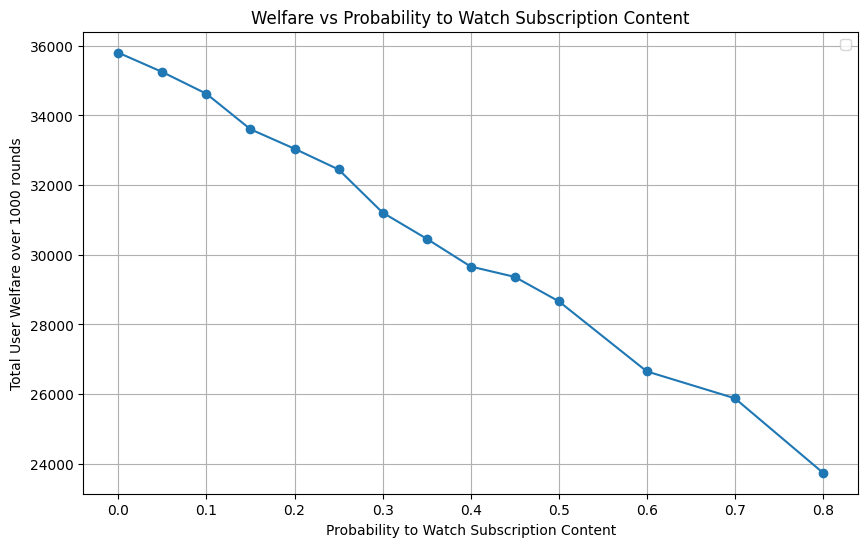

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(num_sub, sub_arr, marker='o')

plt.xlabel('Probability to Watch Subscription Content')
plt.ylabel('Total User Welfare over 1000 rounds')
plt.title('Welfare vs Probability to Watch Subscription Content')
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(0.8900734184105608, 210), (0.8955830469155386, 159), (0.8839571887899697, 195), (0.9046076297094104, 162), (0.8919592573974872, 197), (0.9007821486802802, 186), (0.8972263113908299, 201), (0.898150064662184, 220), (0.9002027802892348, 192), (0.8908263049429341, 191)]


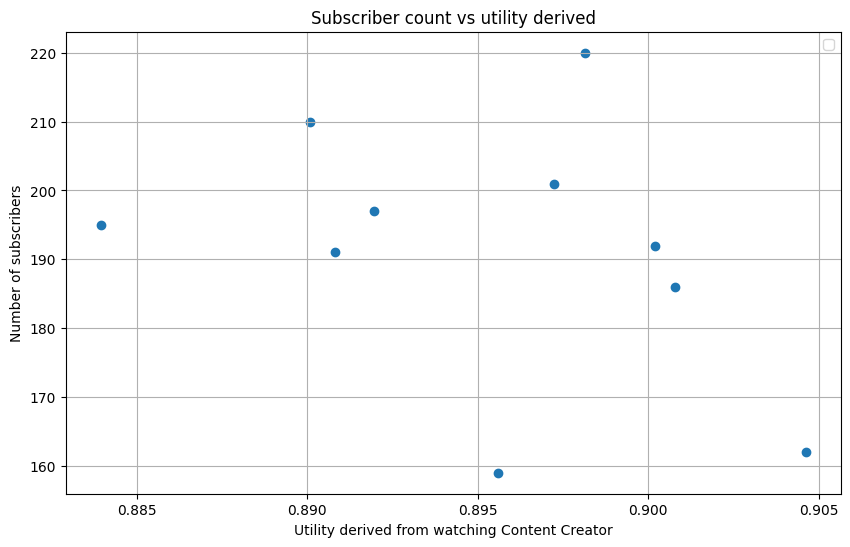

In [30]:
print(sub_util[0])
x = [sub_util[0][i][0] for i in range(len(sub_util[0]))]
y = [sub_util[0][i][1] for i in range(len(sub_util[0]))]
plt.figure(figsize=(10, 6))
plt.scatter(x,y ,marker='o')

plt.xlabel('Utility derived from watching Content Creator')
plt.ylabel('Number of subscribers')
plt.title('Subscriber count vs utility derived')
plt.legend()
plt.grid()
plt.show()